<h2 align=center> Optimize TensorFlow Models For Deployment with TensorRT</h2>

# 1.0 Install TensorFlow-GPU 2.0 and TensorRT Runtime

https://forums.developer.nvidia.com/t/notice-cuda-linux-repository-key-rotation/212772

In [34]:
!echo "20052001" | sudo -S apt-get install python3-libnvinfer 

Reading package lists... Done 
Building dependency tree... Done
Reading state information... Done
python3-libnvinfer is already the newest version (8.6.1.6-1+cuda12.0).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [35]:
!python3 -m pip install --upgrade tensorrt

In [36]:
import tensorrt
print(tensorrt.__version__)

8.6.1


In [1]:
# check TensorRT version
import tensorflow as tf
print("TensorFlow version: ", tf.version.VERSION)
print("TensorRT version: ")
!dpkg -l | grep nvinfer

ModuleNotFoundError: No module named 'tensorflow'

# 2.0 Load Data

In [8]:
!gdown 1I8aXVlt9qY3ldScHvqJvH9M7F72mtf5V

Downloading...
From (original): https://drive.google.com/uc?id=1I8aXVlt9qY3ldScHvqJvH9M7F72mtf5V
From (redirected): https://drive.google.com/uc?id=1I8aXVlt9qY3ldScHvqJvH9M7F72mtf5V&confirm=t&uuid=5ba61f63-b426-4f9a-914c-85f6c3d4ce90
To: /content/[CODE] image_retrieval.zip
100% 2.18G/2.18G [00:18<00:00, 120MB/s]


In [9]:
old_name = r"/content/[CODE] image_retrieval.zip"
new_name = r"/content/image_retrieval.zip"
os.rename(old_name, new_name)

In [10]:
!unzip -q /content/image_retrieval.zip -d /content/image_retrieval

# 3.0 Importing required libraries

In [38]:
# Re-run after Kernel restart
import os
import time
from tqdm import tqdm

import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# 4.0 Config Parameters

In [71]:
root_img_path = "/content/image_retrieval/img/"
root_fearure_path = "/content/"
dic_categories = ['scenery', 'furniture', 'animal', 'plant']
size = (224, 224)

img_feature = []
path_feature = []

In [13]:
def path_to_image(path, size):
    img = image.load_img(path, target_size=size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x


def folder_to_images(folder, size=(224, 224)):

    list_dir = [folder + '/' + name for name in os.listdir(folder) if name.endswith((".jpg", ".png", ".jpeg"))]

    i = 0
    image_arr = np.zeros(shape=(len(list_dir), *size, 3))

    image_path = []
    for path in list_dir:
        try:
            image_arr[i,:] = path_to_image(path, size)
            image_path.append(path)
            i += 1

        except Exception:
            print("error: ", path)
#             os.remove(path)

    image_arr = tf.constant(image_arr, dtype=tf.float32)
    image_path = np.array(image_path)
    return image_arr, image_path

# 4.0 Feature Extracted by Keras Model

In [34]:
class Keras_FeatureExtractor: # Keras Model
    def __init__(self, model_path):
        self.model = ResNet50(weights=model_path, include_top=False, pooling='avg')
    def extract(self, img):
        x = preprocess_input(img)  # Subtracting avg values for each pixel
        feature = self.model.predict(x, verbose=0)  # (1, 2048)
        return feature # Normalize

fe = Keras_FeatureExtractor('/content/image_retrieval/weight_resnet50.h5')

In [35]:
# GPU: Wall time: 5min 31s
%%time
start = time.time()
for folder in tqdm(os.listdir(root_img_path)):
    if folder.split("_")[0] in dic_categories:
        path = root_img_path + folder
        images_np, images_path = folder_to_images(path)
        path_feature.extend(np.array(images_path))
        img_feature.extend(fe.extract(images_np))

end = time.time()
keras_time = end - start

100%|██████████| 125/125 [04:37<00:00,  2.22s/it]

CPU times: user 2min 31s, sys: 37.8 s, total: 3min 9s
Wall time: 4min 37s


In [36]:
del fe

# 5.0 Feture Extracted with TensorRT Model

In [21]:
!pwd

/mnt/q/Career/Projects_AI/image_retrieval


In [ ]:
def Conver_to_TensorRT(model_path='imagenet'):
    model = ResNet50(weights=model_path, include_top=False, pooling='avg')
    # Save the entire model as a TensorFlow SavedModel.
    tf.saved_model.save(model, "./model_TRT")
    converter = trt.TrtGraphConverterV2(input_saved_model_dir='./model_TRT',
                                   precision_mode=trt.TrtPrecisionMode.FP16,
                                    max_workspace_size_bytes=8000000000)
    converter.convert()
    converter.save(output_saved_model_dir='./model_TRT_FP16')

Conver_to_TensorRT('/mnt/q/Career/Projects_AI/image_retrieval/weight_resnet50.h5')

INFO:tensorflow:Assets written to: ./model_TRT/assets


INFO:tensorflow:Assets written to: ./model_TRT/assets


INFO:tensorflow:Linked TensorRT version: (8, 6, 1)


INFO:tensorflow:Linked TensorRT version: (8, 6, 1)


INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)


INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
2024-02-05 17:14:20.737104: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 17:14:20.737158: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-05 17:14:20.737273: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-05 17:14:20.737627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 17:14:20.737664: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


INFO:tensorflow:Clearing prior device assignments in loaded saved model


INFO:tensorflow:Clearing prior device assignments in loaded saved model
2024-02-05 17:14:23.201958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 17:14:23.207427: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-05 17:14:23.210082: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-05 17:14:23.211185: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 17:14:23.211244: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built w

In [38]:
class TRT_FeatureExtractor: # TensorRT Model
    def __init__(self, model_path):
        self.model = tf.saved_model.load(model_path, tags=[tag_constants.SERVING])
        self.infer = self.model.signatures['serving_default']

    def extract(self, img, batch_size=32):
        x = preprocess_input(img)  # Subtracting avg values for each pixel
        features = []
        step = math.ceil(img.shape[0] / batch_size)
        for s in range(step):
          features.extend(self.infer(x[batch_size*s:batch_size*(s+1)])['avg_pool'].numpy())  # (1, 2048)
        return features # Normalize

fe = TRT_FeatureExtractor('/content/model_TRT_FP16')

In [67]:
%%time
start = time.time()
for folder in tqdm(os.listdir(root_img_path)):
    if folder.split("_")[0] in dic_categories:
        path = root_img_path + folder
        image_arr, image_path = folder_to_images(path)
        path_feature.extend(image_path)
        img_feature.extend(fe.extract(image_arr))

end = time.time()
tensorrt_time = end - start

100%|██████████| 125/125 [02:31<00:00,  1.21s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'content/all_fearture.npz'

In [72]:
np.savez_compressed(root_fearure_path+"all_fearture", array1=np.array(path_feature), array2=np.array(img_feature))

In [75]:
loaded = np.load('/content/all_fearture.npz')
print(np.array_equal(path_feature, loaded['array1']))

True


In [68]:
!zip -r /content/model.zip /content/model_TRT_FP16

  adding: content/model_TRT_FP16/ (stored 0%)
  adding: content/model_TRT_FP16/variables/ (stored 0%)
  adding: content/model_TRT_FP16/variables/variables.index (deflated 33%)
  adding: content/model_TRT_FP16/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/model_TRT_FP16/saved_model.pb (deflated 7%)
  adding: content/model_TRT_FP16/fingerprint.pb (stored 0%)
  adding: content/model_TRT_FP16/assets/ (stored 0%)


In [73]:
from google.colab import files
files.download("/content/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 6.0 Extraction time

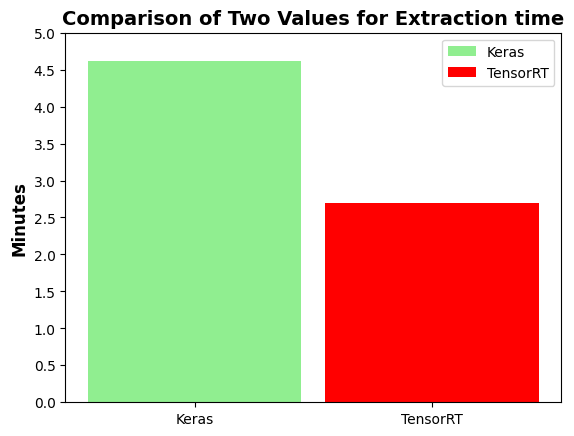

In [65]:
import matplotlib.pyplot as plt

# Define data
data = [keras_time / 60, tensorrt_time / 60]
x_labels = ['Keras', 'TensorRT']

category = 'Extraction time'
colors = ['lightgreen', 'red']

# Prepare bar positions
bar_width = 0.9
x_pos = [0, 1]

# Create bars
plt.bar(x_pos, data, color=colors, width=bar_width, label=x_labels)

# Customize plot
# plt.xlabel('Category', fontweight='bold', fontsize=12)
plt.ylabel('Minutes', fontweight='bold', fontsize=12)
plt.xticks(x_pos, x_labels)
plt.yticks(np.arange(0, max(data) + 0.5, 0.5))
plt.title('Comparison of Two Values for ' + category, fontweight='bold', fontsize=14)
plt.legend()

# Display plot
plt.show()